# Analyse de survie

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Quelques données

On récupère les données disponibles sur *open.data.gouv.fr* [Données hospitalières relatives à l'épidémie de COVID-19](https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/). Ces données ne permettent pas de construire la courbe de [Kaplan-Meier](https://fr.wikipedia.org/wiki/Estimateur_de_Kaplan-Meier). On sait combien de personnes rentrent et sortent chaque jour mais on ne sait pas quand une personne qui sort un 1er avril est entrée.

In [2]:
import numpy.random as rnd

import pandas
df = pandas.read_csv("https://www.data.gouv.fr/en/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7", sep=";")
gr = df[["jour", "rad", "dc"]].groupby(["jour"]).sum()
diff = gr.diff().reset_index(drop=False)
diff.head()

,jour,rad,dc
0,2020-03-18,NaN,NaN
1,2020-03-19,695.0,207.0
2,2020-03-20,806.0,248.0
3,2020-03-21,452.0,151.0
4,2020-03-22,608.0,210.0


In [3]:

def donnees_artificielles(hosp, mu=14, nu=21):
    dt = pandas.to_datetime(hosp['jour'])
    res = []
    for i in range(hosp.shape[0]):
        date = dt[i].dayofyear
        h = hosp.iloc[i, 1]
        delay = rnd.exponential(mu, int(h))
        for j in range(delay.shape[0]):
            res.append([date - int(delay[j]), date, 1])
        h = hosp.iloc[i, 2]
        delay = rnd.exponential(nu, int(h))
        for j in range(delay.shape[0]):
            res.append([date - int(delay[j]), date , 0])
    return pandas.DataFrame(res, columns=["entree", "sortie", "issue"])


data = donnees_artificielles(diff[1:].reset_index(drop=True)).sort_values('entree')
data.head()

,entree,sortie,issue
479479,-211,4,0
503195,-210,13,0
575884,-173,39,0
509354,-161,15,0
479467,-161,4,0


Chaque ligne est une personne, `entree` est le jour d'entrée à l'hôpital, `sortie` celui de la sortie, `issue`, 0 pour décès, 1 pour en vie.

In [4]:
data.describe()

,entree,sortie,issue
count,620853.000000,620853.000000,620853.000000
mean,170.348818,185.216518,0.806598
std,125.380549,124.313339,0.394965
min,-211.000000,1.000000,0.000000
25%,56.000000,86.000000,1.000000
50%,134.000000,146.000000,1.000000
75%,301.000000,316.000000,1.000000
max,366.000000,366.000000,1.000000


Il y a environ 80% de survie dans ces données.

In [5]:
duree = data.sortie - data.entree
deces = (data.issue == 0).astype(numpy.int32)

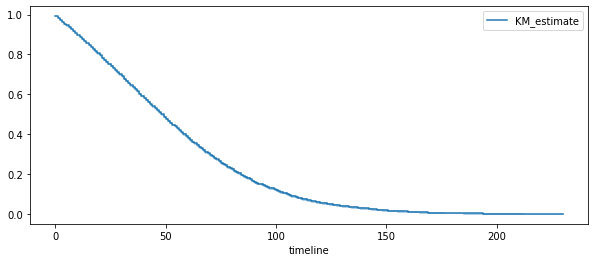

In [6]:
import numpy
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
kmf = KaplanMeierFitter()
kmf.fit(duree, deces)
kmf.plot(ax=ax)
ax.legend();

## Régression de Cox

On reprend les données artificiellement générées et on ajoute une variable identique à la durée plus un bruit mais quasi nul 

In [7]:
import pandas
data_simple = pandas.DataFrame({'duree': duree, 'deces': deces,
                                'X1': duree * 0.57 * deces + numpy.random.randn(data_simple.shape[0]),
                                'X2': duree * (-0.57) * deces + numpy.random.randn(data_simple.shape[0])})
data_simple.head()

,duree,deces,X1,X2
479479,215,1,122.056330,-121.882841
503195,223,1,126.944149,-127.948158
575884,212,1,119.973115,-119.211119
509354,176,1,100.875448,-100.067494
479467,165,1,92.949708,-93.285793


In [8]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data_simple, test_size=0.5)

In [9]:
from lifelines.fitters.coxph_fitter import CoxPHFitter
cox = CoxPHFitter()
cox.fit(data_train[['duree', 'deces', 'X1']], duration_col="duree", event_col="deces",
        show_progress=True)

Iteration 1: norm_delta = 0.13720, step_size = 0.9000, log_lik = -683415.19531, newton_decrement = 2158.82966, seconds_since_start = 1.8
Iteration 2: norm_delta = 0.00553, step_size = 0.9000, log_lik = -681470.51001, newton_decrement = 4.84422, seconds_since_start = 3.7
Iteration 3: norm_delta = 0.00060, step_size = 0.9000, log_lik = -681465.69476, newton_decrement = 0.05596, seconds_since_start = 5.6
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -681465.63876, newton_decrement = 0.00000, seconds_since_start = 7.5
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 310426 total observations, 250053 right-censored observations>

In [10]:
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 310426 total observations, 250053 right-censored observations>
             duration col = 'duree'
                event col = 'deces'
      baseline estimation = breslow
   number of observations = 310426
number of events observed = 60373
   partial log-likelihood = -681465.64
         time fit was run = 2021-02-23 23:51:18 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
X1          0.02       1.02       0.00             0.02             0.02                 1.02                 1.02

              z      p   -log2(p)
covariate                        
X1        65.83 <0.005        inf
---
Concordance = 0.69
Partial AIC = 1362933.28
log-likelihood ratio test = 3899.11 on 1 df
-log2(p) of ll-ratio test = inf

In [11]:
cox = CoxPHFitter()
cox.fit(data_train[['duree', 'deces', 'X2']], duration_col="duree", event_col="deces",
        show_progress=True)
cox.print_summary()

Iteration 1: norm_delta = 0.13708, step_size = 0.9000, log_lik = -683415.19531, newton_decrement = 2155.54601, seconds_since_start = 1.8
Iteration 2: norm_delta = 0.00552, step_size = 0.9000, log_lik = -681473.38870, newton_decrement = 4.82068, seconds_since_start = 3.5
Iteration 3: norm_delta = 0.00060, step_size = 0.9000, log_lik = -681468.59691, newton_decrement = 0.05566, seconds_since_start = 5.3
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -681468.54122, newton_decrement = 0.00000, seconds_since_start = 7.1
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 310426 total observations, 250053 right-censored observations>
             duration col = 'duree'
                event col = 'deces'
      baseline estimation = breslow
   number of observations = 310426
number of events observed = 60373
   partial log-likelihood = -681468.54
         time fit was run = 2021-02-23 23:51:37 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
X2         -0.02       0.98       0.00            -0.02            -0.02                 0.98                 0.98

               z      p   -log2(p)
covariate                         
X2        -65.77 <0.005        inf
---
Concordance = 0.69
Partial AIC = 1362939.08
log-likelihood ratio test = 3893.31 on 1 df
-log2(p) of ll-ratio test = inf